# Project 1: Viral vs. Human Prediction

In [1]:
import warnings
warnings.simplefilter(action='ignore')
from Bio import SeqIO
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import keras.backend as K
from keras import models
import os
from keras.layers import *
from keras.models import Sequential, load_model, Model
from keras.utils import multi_gpu_model 
import matplotlib.pylab as plt
from skimage.transform import resize
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from IPython.display import SVG
from tqdm import tnrange

Using TensorFlow backend.


The encodings are as follows:
1. A = [1, 0, 0, 0, 0]
2. C = [0, 1, 0, 0, 0]
3. G = [0, 0, 1, 0, 0]
4. N = [0, 0, 0, 1, 0]
5. T = [0, 0, 0, 0, 1]

### load data set

In [2]:
root_dir = '/home/ecvol/data/viral/'

In [3]:
X_test = np.load(root_dir + 'test_set.npy')
Y_test = np.load(root_dir + 'test_set_label.npy')
X_train = np.load(root_dir + 'train_set.npy')
Y_train = np.load(root_dir + 'train_set_label.npy')
print("X_train shape: ", X_train.shape, "Y_train shape: ", Y_train.shape, "X_test shape", X_test.shape)

X_train shape:  (1674000, 150, 5, 1) Y_train shape:  (1674000,) X_test shape (1010000, 150, 5, 1)


674000 reads from 337 hpv references
1M reads from chr1

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
split = kfold.split(X_train, Y_train)
train, test = next(split)

earlystopper = EarlyStopping(monitor='loss', patience=7, verbose=1)
for num_filters in [32]:
    for kmer_size in [10]:
        inputs = Input(shape=(150,5,1))
        
        x1 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (1,1), padding='same')(inputs)
        x1 = BatchNormalization()(x1)
        x1 = concatenate([inputs, x1])
        
        x2 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (1,1), padding='same')(x1)
        x2 = BatchNormalization()(x2)
        x2 = concatenate([inputs, x1, x2])
        
        x3 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (2,1), padding='same')(x2)
        x3 = BatchNormalization()(x3)
        x3 = concatenate([inputs, x1, x2, x3])
        
        x4 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (4,1), padding='same')(x3)
        x4 = BatchNormalization()(x4)
        x4 = concatenate([inputs, x1, x2, x3, x4])
        
        x5 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (8,1), padding='same')(x4)
        x5 = BatchNormalization()(x5)
        x5 = concatenate([inputs, x1, x2, x3, x4, x5])
        
        x6 = Conv2D(num_filters, kernel_size=(kmer_size,5), activation='relu', dilation_rate = (1,1), padding='same')(x5)
        x6 = BatchNormalization()(x6)
        x6 = concatenate([inputs, x1, x2, x3, x4, x5, x6])
        
        x7 = Conv2D(num_filters, kernel_size=(1,5), activation='relu', dilation_rate = (1,1), padding='same')(x6)
        x7 = BatchNormalization()(x7)
        x = Dropout(0.3)(x7)
        x = Flatten()(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=[inputs], outputs=[outputs])
        print(model.summary())
        model = multi_gpu_model(model, gpus=8)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[train], Y_train[train], epochs=20, validation_data=(X_train[test], Y_train[test]), 
                  batch_size=2500, verbose=1, callbacks=[earlystopper])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 150, 5, 1)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 150, 5, 32)   1632        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 150, 5, 32)   128         conv2d_43[0][0]                  
__________________________________________________________________________________________________
concatenate_40 (Concatenate)    (None, 150, 5, 33)   0           input_7[0][0]                    
                                                                 batch_normalization_43[0][0]     
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


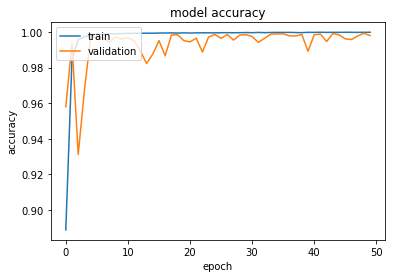

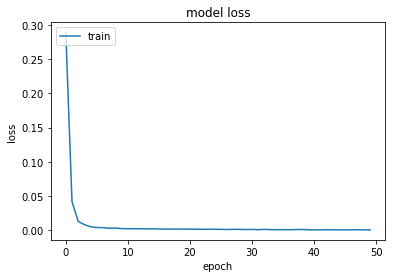

In [8]:
#model.save("viral_pred.h5")
print(history.history.keys())
# #  "Accuracy"

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
predictions = model.predict(X_test, verbose=1)
Y_test = Y_test == 1
print(Y_test[:10], Y_test.shape)

1010000/1010000 [==============================] - 657s 651us/step
[ True  True  True  True  True  True  True  True  True  True] (1010000,)


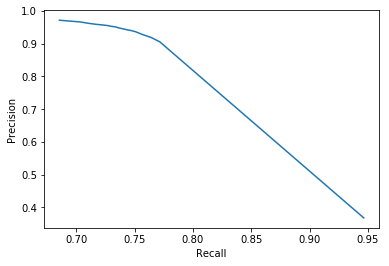

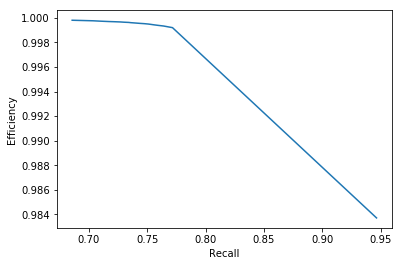

In [25]:
P = []
R = []
E = []
num_viral = 10000
num_hum = 1000000
for t in np.arange(0,1,0.05).tolist():
    temp = (predictions > t)
    TP = 0
    FP = 0
    for i,j in zip(temp, Y_test):
        if (i and j):
            TP += 1
        if (i and not j):
            FP += 1
    
    FN = num_viral - TP
    P.append(TP / (TP + FP))
    R.append(TP / (TP + FN))
    E.append(1 - (FP/(num_hum)))
sns.lineplot(R, P)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
sns.lineplot(R, E)
plt.xlabel('Recall')
plt.ylabel('Efficiency')
plt.show()

In [33]:
np.sum(predictions==0)

984255

In [16]:
v_test = np.load(root_dir + 'v_ref_reads_test.npy')

In [7]:
def de_transform(one_hot):
    one_hot = np.squeeze(one_hot)
    mapping = dict(zip(range(5), 'ACGNT'))
    sequences = []
    for idx, i in enumerate(one_hot):
        seq = np.argmax(i, axis=1)
        seq = [mapping[j] for j in seq]
        sequences.append(''.join(seq))
    return np.array(sequences)

def hamming_distance(train, test): 
    def distance(s1, s2):
        return sum(ch1 != ch2 for ch1,ch2 in zip(s1,s2))
    
    ham_matrix = np.zeros((len(train), len(test)))
    for te_id, te in enumerate(test):
        for tr_id, tr in enumerate(train):
            ham_matrix[tr_id][te_id] = distance(te, tr)
    return ham_matrix